Loaded 1500 image pairs.

--- Training BCE model ---
Epoch 1/5
75/75 - 10s - 140ms/step - accuracy: 0.9892 - loss: 0.2391 - val_accuracy: 1.0000 - val_loss: 0.1495
Epoch 2/5
75/75 - 9s - 119ms/step - accuracy: 1.0000 - loss: 0.1084 - val_accuracy: 1.0000 - val_loss: 0.0774
Epoch 3/5
75/75 - 9s - 118ms/step - accuracy: 1.0000 - loss: 0.0600 - val_accuracy: 1.0000 - val_loss: 0.0464
Epoch 4/5
75/75 - 9s - 117ms/step - accuracy: 1.0000 - loss: 0.0379 - val_accuracy: 1.0000 - val_loss: 0.0311
Epoch 5/5
75/75 - 9s - 117ms/step - accuracy: 1.0000 - loss: 0.0264 - val_accuracy: 1.0000 - val_loss: 0.0225

--- Training Contrastive model ---
Epoch 1/5
150/150 - 19s - 125ms/step - accuracy: 0.3971 - loss: 0.2588 - val_accuracy: 0.9984 - val_loss: 0.6364
Epoch 2/5
150/150 - 20s - 133ms/step - accuracy: 0.3896 - loss: 0.2452 - val_accuracy: 0.9062 - val_loss: 0.4274
Epoch 3/5
150/150 - 18s - 118ms/step - accuracy: 0.3858 - loss: 0.2388 - val_accuracy: 0.9918 - val_loss: 0.5740
Epoch 4/5
150/150 - 1

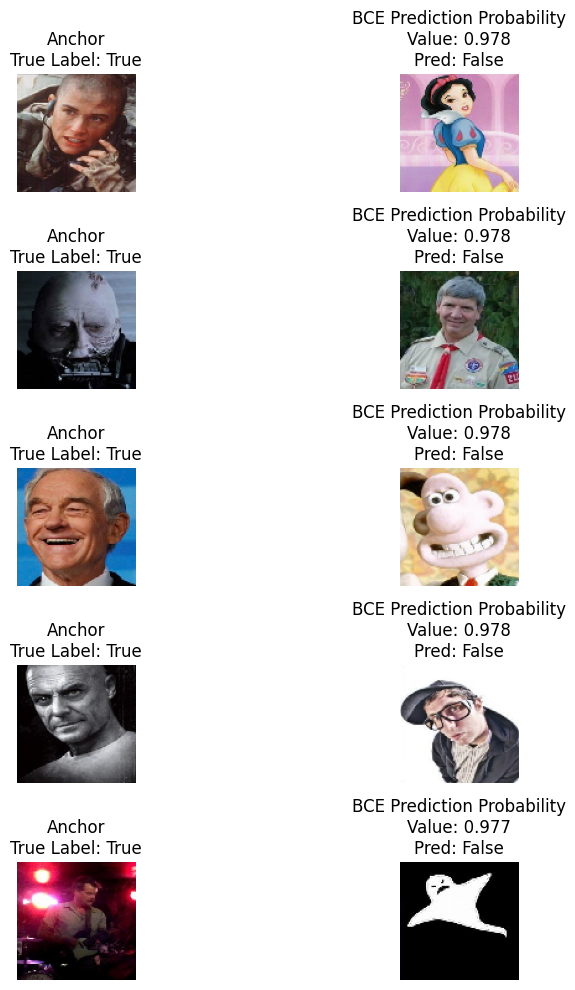

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


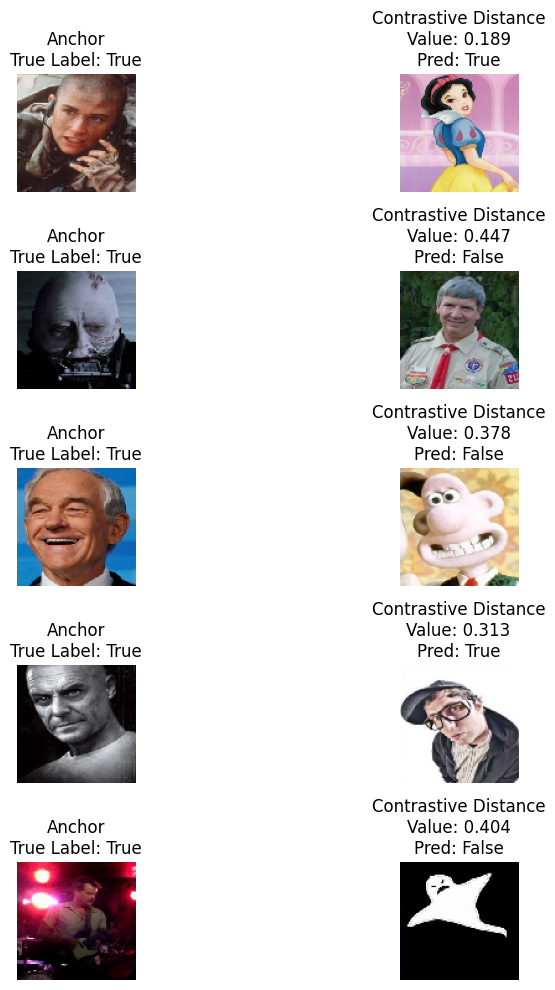

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


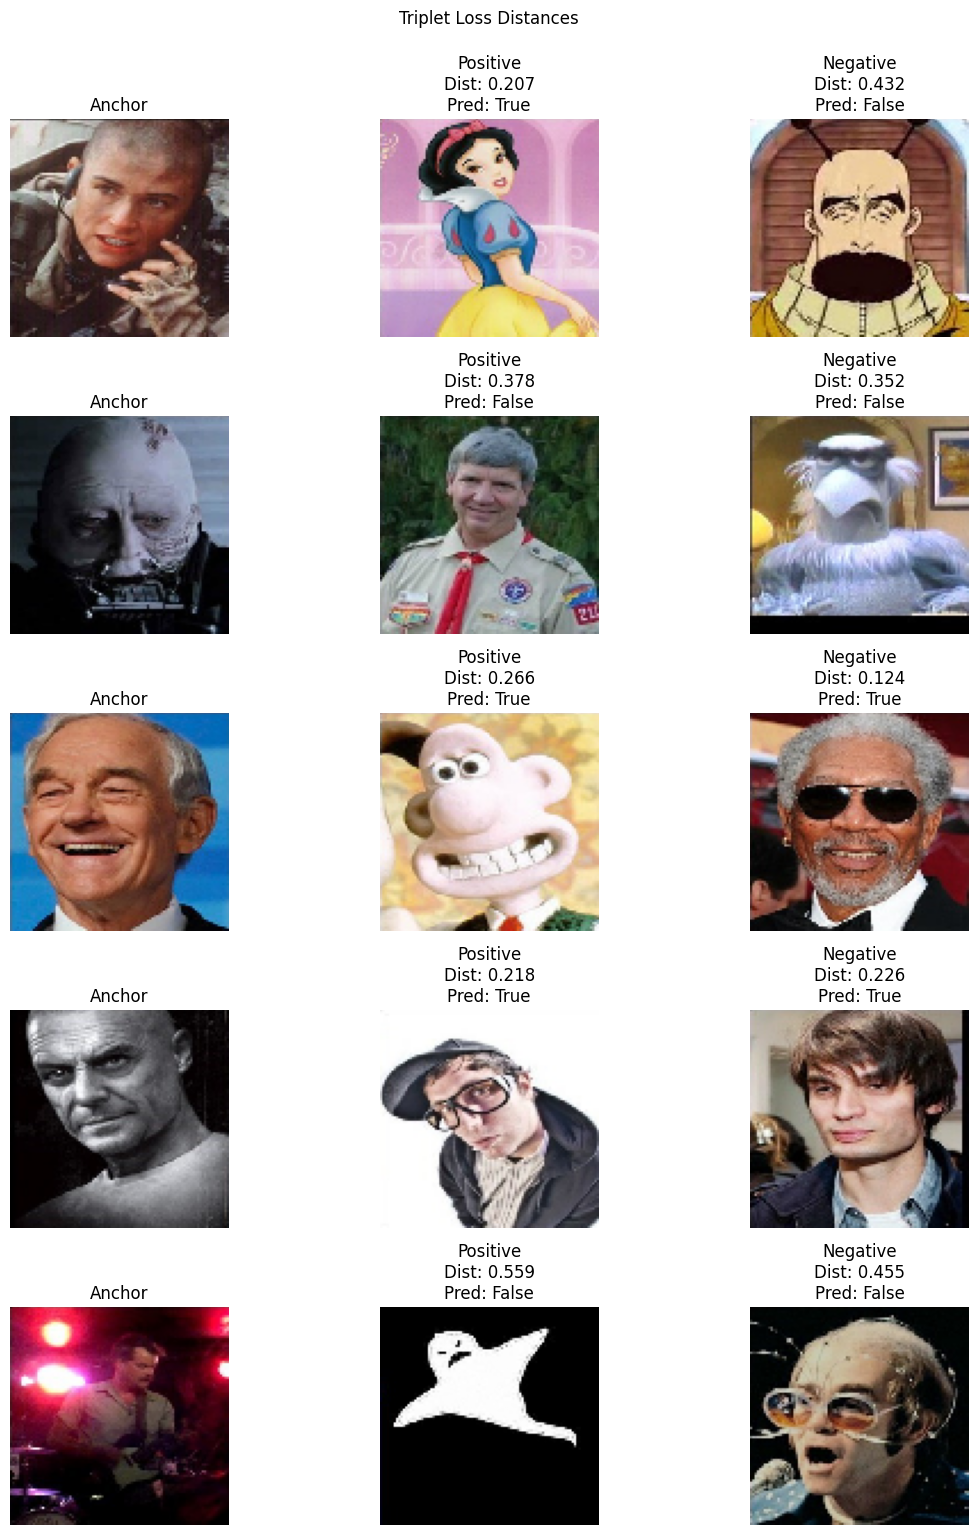

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import roc_curve
import gc

# --- PARAMETERS ---
IMG_SIZE = (96, 96)
BATCH_SIZE = 16
EPOCHS = 5
MARGIN = 1.0
ALPHA = 0.2
DATASET_SIZE_LIMIT = 1500

# --- IMAGE LOADING ---
def load_images_from_path(path, img_size=IMG_SIZE):
    """Loads images from a directory, resizes, and normalizes them."""
    images = []
    if not path.exists():
        print(f"Error: Directory not found at {path}")
        return np.array(images)
    files = sorted(list(path.glob('*')))
    for f in files:
        img = load_img(f, target_size=img_size)
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

def prepare_datasets():
    left_imgs = load_images_from_path(Path("Data/left"))
    right_imgs = load_images_from_path(Path("Data/right"))
    if len(left_imgs) == 0 or len(right_imgs) == 0:
        raise RuntimeError("No images loaded. Check 'Data/left' and 'Data/right'.")
    limit = min(DATASET_SIZE_LIMIT, len(left_imgs), len(right_imgs))
    return left_imgs[-limit:], right_imgs[-limit:]

left_imgs, right_imgs = prepare_datasets()
print(f"Loaded {len(left_imgs)} image pairs.")

# --- NEGATIVE PAIRS ---
right_imgs_neg = np.copy(right_imgs)
np.random.shuffle(right_imgs_neg)
pos_labels = np.ones(len(left_imgs))
neg_labels = np.zeros(len(left_imgs))

# --- BASE NETWORK ---
def create_base_network(input_shape):
    inp = Input(input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Lambda(lambda t: K.l2_normalize(t, axis=1))(x)
    return Model(inp, x, name="base_network")

input_shape = left_imgs.shape[1:]

def clear_memory():
    tf.keras.backend.clear_session()
    gc.collect()

# --- MODEL BUILDERS ---
def build_bce_model(input_shape):
    base = create_base_network(input_shape)
    a, b = Input(shape=input_shape), Input(shape=input_shape)
    fa, fb = base(a), base(b)
    concat = layers.concatenate([fa, fb])
    out = layers.Dense(1, activation='sigmoid')(concat)
    model = Model([a, b], out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model, base

def build_contrastive_model(input_shape, margin=MARGIN):
    def euclidean_distance(vects):
        x, y = vects
        return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
    def contrastive_loss(margin=margin):
        def loss(y_true, y_pred):
            y_true = tf.cast(y_true, y_pred.dtype)
            square_pred = K.square(y_pred)
            margin_square = K.square(K.maximum(margin - y_pred, 0))
            return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
        return loss
    base = create_base_network(input_shape)
    a, b = Input(shape=input_shape), Input(shape=input_shape)
    fa, fb = base(a), base(b)
    dist = layers.Lambda(euclidean_distance)([fa, fb])
    model = Model([a, b], dist)
    model.compile(optimizer='adam', loss=contrastive_loss(), metrics=['accuracy'])
    return model, base

def build_triplet_model(input_shape, alpha=ALPHA):
    def triplet_loss(alpha=alpha):
        def loss(y_true, y_pred):
            anchor = y_pred[:, 0:128]
            pos = y_pred[:, 128:256]
            neg = y_pred[:, 256:384]
            pos_dist = K.sum(K.square(anchor - pos), axis=1)
            neg_dist = K.sum(K.square(anchor - neg), axis=1)
            basic_loss = pos_dist - neg_dist + alpha
            return K.mean(K.maximum(basic_loss, 0.0))
        return loss
    base = create_base_network(input_shape)
    anchor = Input(shape=input_shape)
    pos = Input(shape=input_shape)
    neg = Input(shape=input_shape)
    fa, fp, fn = base(anchor), base(pos), base(neg)
    merged = layers.concatenate([fa, fp, fn])
    model = Model([anchor, pos, neg], merged)
    model.compile(optimizer='adam', loss=triplet_loss(), metrics=['accuracy'])
    return model, base

# --- TRAINING ---
def train_model(model, x, y, batch_size=BATCH_SIZE, epochs=EPOCHS, val_split=0.2):
    model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_split=val_split, verbose=2)
    clear_memory()

print("\n--- Training BCE model ---")
model_bce, base_bce = build_bce_model(input_shape)
train_model(model_bce, [left_imgs, right_imgs], pos_labels)

print("\n--- Training Contrastive model ---")
model_contrastive, base_contrastive = build_contrastive_model(input_shape)
x_contrastive = [np.concatenate([left_imgs, left_imgs]), np.concatenate([right_imgs, right_imgs_neg])]
y_contrastive = np.concatenate([pos_labels, neg_labels])
train_model(model_contrastive, x_contrastive, y_contrastive)

print("\n--- Training Triplet model ---")
model_triplet, base_triplet = build_triplet_model(input_shape)
dummy_y = np.zeros(len(left_imgs))
train_model(model_triplet, [left_imgs, right_imgs, right_imgs_neg], dummy_y)

# --- THRESHOLD SELECTION ---
def find_best_threshold(labels, preds, invert=False):
    fpr, tpr, thresholds = roc_curve(labels, -preds if invert else preds)
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    return -best_thresh if invert else best_thresh

print("\n--- Calculating Optimal Thresholds ---")
# BCE
pos_bce_preds = model_bce.predict([left_imgs, right_imgs]).flatten()
neg_bce_preds = model_bce.predict([left_imgs, right_imgs_neg]).flatten()
bce_all_preds = np.concatenate([pos_bce_preds, neg_bce_preds])
bce_all_labels = np.concatenate([pos_labels, neg_labels])
bce_best_thresh = find_best_threshold(bce_all_labels, bce_all_preds)
print(f"BCE best threshold: {bce_best_thresh:.3f}")

# Contrastive
pos_contrastive_dists = model_contrastive.predict([left_imgs, right_imgs]).flatten()
neg_contrastive_dists = model_contrastive.predict([left_imgs, right_imgs_neg]).flatten()
contrastive_all_dists = np.concatenate([pos_contrastive_dists, neg_contrastive_dists])
contrastive_all_labels = np.concatenate([pos_labels, neg_labels])
contrastive_best_thresh = find_best_threshold(contrastive_all_labels, contrastive_all_dists, invert=True)
print(f"Contrastive best threshold: {contrastive_best_thresh:.3f}")

# Triplet
embed_anchor = base_triplet.predict(left_imgs)
embed_positive = base_triplet.predict(right_imgs)
embed_negative = base_triplet.predict(right_imgs_neg)
pos_triplet_dists = np.linalg.norm(embed_anchor - embed_positive, axis=1)
neg_triplet_dists = np.linalg.norm(embed_anchor - embed_negative, axis=1)
triplet_all_dists = np.concatenate([pos_triplet_dists, neg_triplet_dists])
triplet_all_labels = np.concatenate([pos_labels, neg_labels])
triplet_best_thresh = find_best_threshold(triplet_all_labels, triplet_all_dists, invert=True)
print(f"Triplet best threshold: {triplet_best_thresh:.3f}")

# --- VISUALIZATION ---
def plot_pairs_with_labels(images1, images2, labels, preds, threshold, title, is_distance=False):
    plt.figure(figsize=(10, 2 * len(images1)))
    for i in range(len(images1)):
        pred_val = preds[i]
        pred_label = "True" if (pred_val <= threshold if is_distance else pred_val >= threshold) else "False"
        plt.subplot(len(images1), 2, 2 * i + 1)
        plt.imshow(images1[i])
        plt.axis('off')
        plt.title(f"Anchor\nTrue Label: {bool(labels[i])}")
        plt.subplot(len(images1), 2, 2 * i + 2)
        plt.imshow(images2[i])
        plt.axis('off')
        plt.title(f"{title}\nValue: {pred_val:.3f}\nPred: {pred_label}")
    plt.tight_layout()
    plt.show()

def plot_triplets_with_labels(anchor_imgs, pos_imgs, neg_imgs, pos_dists, neg_dists, threshold, title):
    plt.figure(figsize=(12, 3 * len(anchor_imgs)))
    for i in range(len(anchor_imgs)):
        pos_pred_label = "True" if pos_dists[i] <= threshold else "False"
        neg_pred_label = "True" if neg_dists[i] <= threshold else "False"
        plt.subplot(len(anchor_imgs), 3, 3 * i + 1)
        plt.imshow(anchor_imgs[i]); plt.axis('off'); plt.title('Anchor')
        plt.subplot(len(anchor_imgs), 3, 3 * i + 2)
        plt.imshow(pos_imgs[i]); plt.axis('off'); plt.title(f'Positive\nDist: {pos_dists[i]:.3f}\nPred: {pos_pred_label}')
        plt.subplot(len(anchor_imgs), 3, 3 * i + 3)
        plt.imshow(neg_imgs[i]); plt.axis('off'); plt.title(f'Negative\nDist: {neg_dists[i]:.3f}\nPred: {neg_pred_label}')
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

print("\n--- Visualizing Sample Predictions ---")
sample_idx = list(range(min(5, len(left_imgs))))
left_sample = left_imgs[sample_idx]
right_sample = right_imgs[sample_idx]
neg_sample = right_imgs_neg[sample_idx]
labels_sample = pos_labels[sample_idx]

bce_preds_sample = model_bce.predict([left_sample, right_sample]).flatten()
plot_pairs_with_labels(left_sample, right_sample, labels_sample, bce_preds_sample, bce_best_thresh, "BCE Prediction Probability", is_distance=False)

contrastive_preds_sample = model_contrastive.predict([left_sample, right_sample]).flatten()
plot_pairs_with_labels(left_sample, right_sample, labels_sample, contrastive_preds_sample, contrastive_best_thresh, "Contrastive Distance", is_distance=True)

embed_anchor_s = base_triplet.predict(left_sample)
embed_positive_s = base_triplet.predict(right_sample)
embed_negative_s = base_triplet.predict(neg_sample)
pos_dist_s = np.linalg.norm(embed_anchor_s - embed_positive_s, axis=1)
neg_dist_s = np.linalg.norm(embed_anchor_s - embed_negative_s, axis=1)
plot_triplets_with_labels(left_sample, right_sample, neg_sample, pos_dist_s, neg_dist_s, triplet_best_thresh, "Triplet Loss Distances")